In [2]:
import pandas as pd
import numpy as np
import glob, time, os, cv2, csv

try:
    %env CUDA_DEVICE_ORDER=PCI_BUS_ID
    %env CUDA_VISIBLE_DEVICES=0
except NameError:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import shutil
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())  ## to use which GPU in use


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9271522762120769577
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10418803332537818409
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7854748468364826849
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 95682560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11797243730617701199
physical_device_desc: "device: 0, name: GeF

In [2]:
##Loading the model
model = load_model('/home/Erdal.Genc/covid_work/Padchest_work/')

InvalidArgumentError: assertion failed: [0] [Op:Assert] name: EagerVariableNameReuse

In [3]:
# Display
from IPython.display import Image
import matplotlib.cm as cm
img_one = '/mnt/dsets/ChestXrays/PadChest/image_zips/0/99744230716892055301280916536204938895_oo9nk5.png'

'2.1.0'

In [ ]:
import tensorflow as tf

from tf_explain.core.grad_cam import GradCAM


model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
img = tf.keras.preprocessing.image.load_img(img_one, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

data = ([img], None)

tabby_cat_class_index = 13
explainer = SmoothGrad()
# Compute SmoothGrad on VGG16
grid = GradCAM().explain(data, model, tabby_cat_class_index, 20, 1.)
explainer.save(grid, '.', 'smoothgrad_2.png')
    

TypeError: Image data of dtype <U93 cannot be converted to float

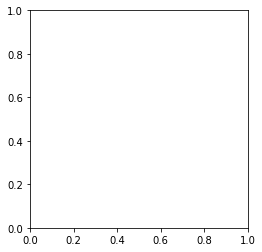

In [11]:
plt.imshow(img_one)

In [10]:
def preprocess(img):
    img= image.load_img(img, target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img
image_1 = preprocess(img_one)
predict = model.predict(image_1)
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)
last_conv = model.get_layer('res5c_branch2c')
grads = K.gradients(model.output[:,13],last_conv.output)[0]
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([image_1])
keras
 
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)

for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)

heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)
upsample = resize(heatmap, (224,224),preserve_range=False)
plt.imshow(image)
plt.imshow(heatmap,alpha=0.5)
plt.show()

Target Class = 13


RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [1]:

from tensorflow.keras.models import Model

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f
def read_and_preprocess_img(path, size=(224,224)):
    img = load_img(path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [5]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
layer_name = 'res5c_branch2c'
print(model.get_layer(layer_name).output)
print(model.get_layer(layer_name))
act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)


Using TensorFlow backend.


NameError: name 'model' is not defined

In [4]:
layer_name = 'res5c_branch2c'
img_array = read_and_preprocess_img(img_one, size=(224,224))
score_cam = ScoreCam(model,img_array,layer_name)
plt.imshow(score_cam)
plt.show()

NameError: name 'load_img' is not defined